# Explore PICO data

In [41]:
# generic imports
import ast
import collections
import re
import spacy
import scispacy
import time
import numpy as np
from collections import Counter
from itertools import groupby
import itertools
from operator import itemgetter


# 
import pandas as pd

# visualiation imports 
from matplotlib_dashboard import MatplotlibDashboard
import matplotlib.pyplot as plt

In [2]:
load_data = '/mnt/nas2/data/systematicReview/semeval2023/data/parsed/st2_train_parsed.tsv'

In [3]:
df = pd.read_csv(load_data, sep='\t')

In [4]:
df.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,4,rxyk1d,t5_2s1h9,Ive read that amnesia always followed a tonic ...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",[deleted by user]\n[removed],N.A.,N.A.,[['N.A.']],[['N.A.']]


In [5]:
picos_mapping = {'population': 1, 'intervention':2, 'outcome':3}

### class vs out-of-the-class tokens

In [6]:
def class_ratio(labels, entity):
    
    entity_num = picos_mapping[entity]
    
    out_of_span_counter = 0
    class_counter = 0
    
    for i in labels:
        lab_i = ast.literal_eval(i)
        if len(lab_i)>1:
            counts = collections.Counter( lab_i )
            counts = dict( counts )
            out_of_span_counter = out_of_span_counter + counts[0]
            if entity_num in counts:
                class_counter = class_counter + counts[entity_num]
                
    count_summary = {str(entity): class_counter, 'oos':out_of_span_counter}
                
    return count_summary

{'population': 469, 'oos': 82592}
{'intervention': 882, 'oos': 82592}
{'outcome': 879, 'oos': 82592}


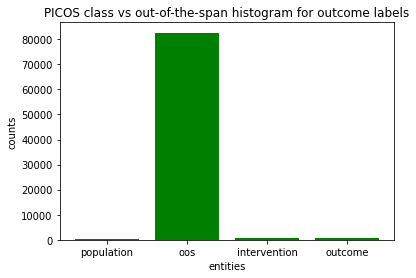

In [7]:
for x in [ 'population', 'intervention', 'outcome' ]:
    count_summary = class_ratio(df.labels, x)
    print( count_summary )
    plot.bar(list(count_summary.keys()), count_summary.values(), color='g')
    plot.title(f'PICOS class vs out-of-the-span histogram for {x} labels')
    plot.xlabel('entities')
    plot.ylabel('counts')

### Inspect the PICO annotations

In [8]:
picos_colors_mapping = {'population': 'green', 'intervention': 'red', 'outcome': 'blue'}

In [9]:
def inspect_annots(entity):
    terms_all = []
    terms_lengths = []

    for counter, (tok, lab) in enumerate(zip(df.tokens.values, df.labels.values)):
        
        tok = ast.literal_eval(tok)
        lab = ast.literal_eval(lab)
        
        
        captured_ind = []
        captured_cons_ind = []
        for counter_i, (t, l) in  enumerate(zip(tok, lab)):
            if l == picos_mapping[entity]:
                captured_ind.append( counter_i )

        for k, g in groupby(enumerate(captured_ind), lambda ix : ix[0] - ix[1]):
            label_indices = list(map(itemgetter(1), g))
            captured_cons_ind.append( label_indices )

        #print('\n-----------------------------------------------')

        for x in captured_cons_ind:
            #print(x)
            p_term = [tok[x_i] for x_i in x]
            terms_lengths.append( len(p_term) )
            p_term = ' '.join(p_term)
            terms_all.append( p_term )
            
            
    return terms_lengths, terms_all

In [28]:
def plot_common_words(description_list, n):
    # Assign the Counter instance `most_common` call to a variable:
    word_frequency = Counter(" ".join(description_list).split()).most_common(n)

    # `most_common` returns a list of (word, count) tuples
    words = [word for word, _ in word_frequency]
    counts = [counts for _, counts in word_frequency]
    
    fig = plt.figure(figsize=(7, 5))
    plot.bar(words, counts, color = picos_colors_mapping[picos_i])
    plot.title("10 most frequent tokens in the list")
    plot.ylabel("Frequency")
    plot.xlabel("Words")
    plot.xticks(rotation=45, ha='right')

    plot.show()

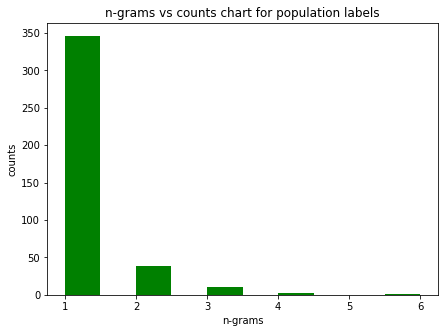

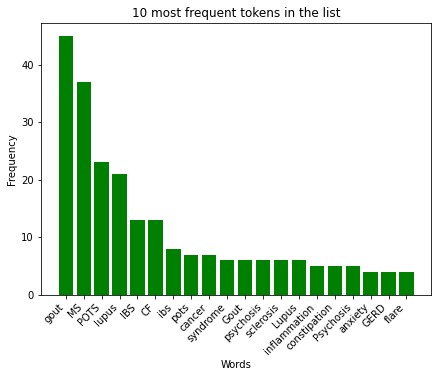

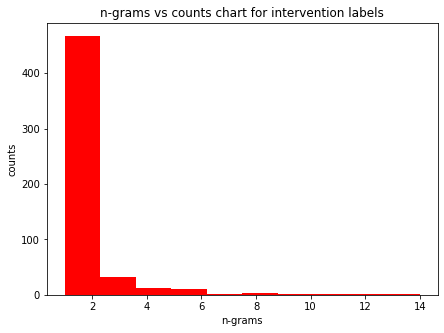

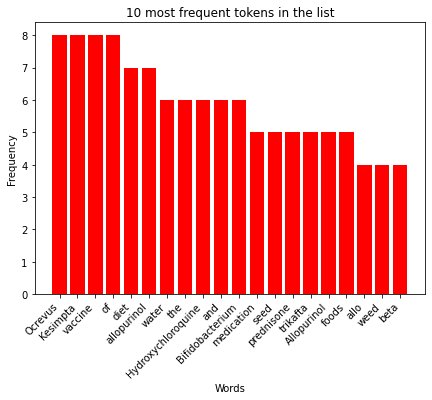

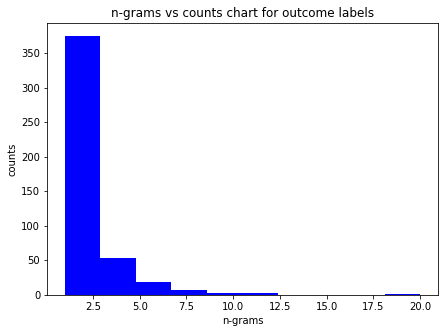

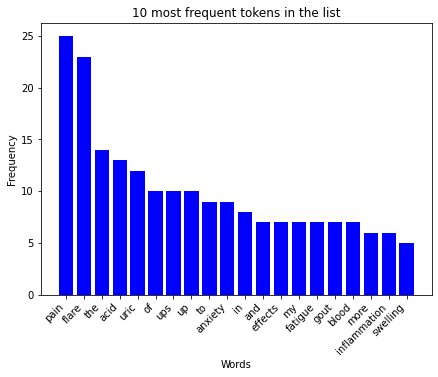

In [29]:
for picos_i in [ 'population', 'intervention', 'outcome' ]:
    
    terms_i_lengths, terms_i_all = inspect_annots(picos_i)   

    fig = plt.figure(figsize=(7, 5))
    plot.hist( terms_i_lengths, bins=10, color = picos_colors_mapping[picos_i]) 
    plot.title(f'n-grams vs counts chart for {picos_i} labels')
    plot.xlabel('n-grams')
    plot.ylabel('counts')
        
    plot.show()
    
    plot_common_words(terms_i_all, 20)

### Class overlap

In [39]:
def class_overlap(tokens, labels):
    
    par = []
    inter = []
    out = []
    oos = []
    
    for t, l in zip(tokens, labels):
        tok_i = ast.literal_eval(t)
        lab_i = ast.literal_eval(l)
        
        if len(lab_i)>1:
            
            for i,j in zip(tok_i, lab_i):
                if j == 0:
                    oos.append(i)
                if j == 1:
                    par.append(i)
                if j == 2:
                    out.append(i)
                if j == 3:
                    oos.append(i)

    return { 'participant': par, 'intervention': inter, 'outcome': out, 'oos': oos }


tokens_dict = class_overlap(df.tokens, df.labels)

In [44]:
for pair in itertools.combinations(['participant','intervention','outcome','oos'], 2):
    
    t1 = tokens_dict[ pair[0] ]
    t2 = tokens_dict[ pair[1] ]
    
    common = list(set(t1).intersection(t2))
    print( f'Common tokens between {pair[0]} and {pair[1]}: {common} \n' )
    print(' -------------------------------------------------------------------- ')

Common tokens between participant and intervention: [] 

 -------------------------------------------------------------------- 
Common tokens between participant and outcome: ['covid', 'tysabri', 'certain', 'tachycardia', 'pots', 'Fibrosis', 'alcohol', 'bupropion', 'patients', 'COVID', 'pylori', 'cf', 'acid', 'stress', 'blood', 'SLE', 'ANA', 'cancer', 'inflammation', 'Acid', 'high', 'Cystic', 'diet', 'Syndrome', 'with', 'healthy', 'vaccines'] 

 -------------------------------------------------------------------- 
Common tokens between participant and oos: ['vertigo', 'partial', 'compromised', 'seizure', 'flare', 'Gout', 'syndrome', 'COVID', 'PPMS', 'cf', 'sclerosis', 'twins', 'acid', 'Psoriasis', 'rash', 'diarrhea', 'people', 'baby', 'ANA', 'IST', 'inflammation', 'health', 'schizophrenia', 'hiatal', 'ibs', 'depression', 'attack', 'SPMS', 'disorder', 'schizophrenic.', 'testosterone', 'bp', 'immune', 'CFLD', 'healthy', 'Covid', 'R75q', 'hernia', 'Lupus', 'tachycardia', 'pots', 'Psychosi

### Examine individual PICO

In [33]:
import spacy

#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')

In [35]:
for picos_i in [ 'outcome' ]:
    
    _, terms_i_all = inspect_annots(picos_i)
    
    for i in terms_i_all:
        print(i)

worsening of old symptoms
back pain
chronic pain
vertigo/dizziness
blurred
doubled
anxious
burning sensation
swelling
tightness
scared
Autonomic dysfunction
aches
pain
flare ups
bloating
abdominal cramps
BM
flare-ups
joints
heartburn
bloating
constipation
diarrhea
stomach cramps
prevent future flare-ups
to mitigate any pain from flare-ups caused by the Allo
did nothing for the pain,
brain volume loss
Life-Changing
chest and back pain
sore throats.
Bloating
pain
stress
Incomplete evacuation
Bloating
Green Stool
Anxiety
Headaches
irritated
side effects
Amnesia
coffeee
ache
tired
fevers
nausea/dizzy
burning
urination
pain
high uric acid
A Fib
pins jn my skin
crappy
curcumin
ugly sobs
Lifechanging
seizure
risk for lung cance
extremely constipated
flare up
Vaccine
affecting nerves
thighs become incredibly itchy and prickly
delays the reaction
more mucus
thicker mucus
tight chest
wheezing
uric acid
relapse
fatigue
body aches
swelling
fatigue
flare-up
one
protect their immunocompromised infan